Mechanisms found:  True
Initiating HL23PN1 population...
Loaded template
t = 100.0 ms
t = 200.0 ms
t = 300.0 ms
t = 400.0 ms
t = 500.0 ms
t = 600.0 ms
t = 700.0 ms
t = 800.0 ms
t = 900.0 ms
t = 1000.0 ms
t = 1100.0 ms
t = 1200.0 ms


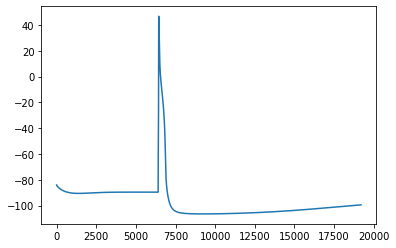

In [2]:
####################################################################
# Import Modules and load relevant files
####################################################################
import os
from os.path import join
import sys
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy
from scipy import signal as ss
from scipy import stats as st
from mpi4py import MPI
import math
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from net_params import *

print('Mechanisms found: ', os.path.isfile('mod/x86_64/special'))
neuron.h('forall delete_section()')
neuron.load_mechanisms('mod/')
h.load_file('net_functions.hoc')
h.load_file('models/biophys_HL23PN1.hoc')
h.load_file('models/biophys_HL23MN1.hoc')
h.load_file('models/biophys_HL23BN1.hoc')
h.load_file('models/biophys_HL23VN1.hoc')

L23_pop_args = {'radius':250,
                'loc':-800,
                'scale':500,
                'cap': float(200)}

rotations = {'HL23PN1':{'x':1.57,'y':2.62},
             'HL23MN1':{'x':1.77,'y':2.77},
             'HL23BN1':{'x':1.26,'y':2.57},
             'HL23VN1':{'x':-1.57,'y':3.57}}

networkParams = {
    'dt' : 0.0625,
    'tstop' : 1200,
    'v_init' : -84,
    'celsius' : 34,
    'OUTPUTPATH' : os.getcwd(),
    'verbose' : False}


####################################################################
# Create Population Function
####################################################################
def generateSubPop(popsize,mname,popargs,Gou,Gtonic):
    print('Initiating ' + mname + ' population...')
    morphpath = 'morphologies/' + mname + '.swc'
    templatepath = 'models/NeuronTemplate.hoc'
    templatename = 'NeuronTemplate'

    cellParams = {
        'morphology': morphpath,
        'templatefile': templatepath,
        'templatename': templatename,
        'templateargs': morphpath,
        'v_init': -80,
        'passive': False,
        'dt': 0.0625,
        'tstart': 0.,
        'tstop': 1200,#defaults to 100
        'nsegs_method': None,
        'pt3d': False,
        'delete_sections': False,
        'verbose': False}

    rotation = rotations.get(mname)

    popParams = {
        'CWD': None,
        'CELLPATH': None,
        'Cell' : LFPy.NetworkCell,
        'POP_SIZE': popsize,
        'name': mname,
        'cell_args' : cellParams,
        'pop_args' : popargs,
        'rotation_args' : rotation}

    network.create_population(**popParams)
    

    for cellind in range(0,len(network.populations[mname].cells)): #0 is redundant?
        biophys = 'h.biophys_' + mname + '(network.populations[\'' + mname + '\'].cells[' + str(cellind) + '].template)'
        exec(biophys)
        rseed = 1234
        h.createArtificialSyn(rseed,network.populations[mname].cells[cellind].template,Gou)
        h.addTonicInhibition(network.populations[mname].cells[cellind].template,Gtonic)
####################################################################
# Run Simulation
####################################################################
network = Network(**networkParams)
generateSubPop(1, 'HL23PN1', L23_pop_args,0,0)
print('Loaded template')

            
for cell in network.populations['HL23PN1'].cells:
    delays = [400]
    pointprocesses = []
    pre_stimuli = []
    for i in range(len(delays)):
        pointprocesses.append({
            'idx' : 0,
            'record_current' : True,
            'pptype' : 'IClamp',
            'amp' : 2.4,
            'dur' : 2,
            'delay': delays[i]})
    for pointprocess in pointprocesses:
        pre_stimuli.append(LFPy.StimIntElectrode(cell, **pointprocess))
#     LFPy.StimIntElectrode(cell, idx=0, record_current=True, pptype='IClamp', amp=2.4, dur=700, delay=300)

network.simulate()

for cell in network.populations['HL23PN1'].cells:
    plt.plot(cell.somav)
    
# network.pc.gid_clear()
# electrode = None
# syn = None
# synapseModel = None
# for population in network.populations.values():
#     for cell in population.cells:
#         cell = None
#         population.cells = None
#     population = None
#     pop = None
#     network = None
#     neuron.h('forall delete_section()')

In [11]:
for i,cell in enumerate(network.populations['HL23PN1'].cells):
    if i==0:
        h('access NeuronTemplate[0].soma[0]')
        h.psection()

NeuronTemplate[0].soma[0] { nseg=1  L=11.461  Ra=263.026
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=11.461}
	insert capacitance { cm=1}
	insert pas { g_pas=8.79798e-05 e_pas=-90.5226}
	insert SK { gbar_SK=0.707955}
	insert CaDynamics { gamma_CaDynamics=2.62938e-05 decay_CaDynamics=432.068 depth_CaDynamics=0.1 minCai_CaDynamics=0.0001}
	insert Ca_LVA { gbar_Ca_LVA=0.00996296}
	insert Ca_HVA { gbar_Ca_HVA=0.000991171}
	insert ca_ion {}
	insert K_T { gbar_K_T=0.00535282}
	insert K_P { gbar_K_P=0.0368365}
	insert Kv3_1 { gbar_Kv3_1=0.20343}
	insert Im { gbar_Im=0.0040078}
	insert k_ion { ek=-107}
	insert Ih { gbar_Ih=0.00217274}
	insert NaTs { gbar_NaTs=1.81224}
	insert Nap { gbar_Nap=0.000825414}
	insert na_ion { ena=53}
	insert tonic { g_tonic=0 e_gaba_tonic=-75}
	insert IClamp { del=400 dur=2 amp=2.4}
}


In [7]:
for cell in network.populations['HL23PN1'].cells:
    for sec in cell.allseclist:
        for i, seg in enumerate(sec):
            print(i, seg)

0 NeuronTemplate[0].soma[0](0.5)
0 NeuronTemplate[0].dend[0](0.5)
0 NeuronTemplate[0].dend[1](0.0714286)
1 NeuronTemplate[0].dend[1](0.214286)
2 NeuronTemplate[0].dend[1](0.357143)
3 NeuronTemplate[0].dend[1](0.5)
4 NeuronTemplate[0].dend[1](0.642857)
5 NeuronTemplate[0].dend[1](0.785714)
6 NeuronTemplate[0].dend[1](0.928571)
0 NeuronTemplate[0].dend[2](0.5)
0 NeuronTemplate[0].dend[3](0.1)
1 NeuronTemplate[0].dend[3](0.3)
2 NeuronTemplate[0].dend[3](0.5)
3 NeuronTemplate[0].dend[3](0.7)
4 NeuronTemplate[0].dend[3](0.9)
0 NeuronTemplate[0].dend[4](0.0714286)
1 NeuronTemplate[0].dend[4](0.214286)
2 NeuronTemplate[0].dend[4](0.357143)
3 NeuronTemplate[0].dend[4](0.5)
4 NeuronTemplate[0].dend[4](0.642857)
5 NeuronTemplate[0].dend[4](0.785714)
6 NeuronTemplate[0].dend[4](0.928571)
0 NeuronTemplate[0].dend[5](0.5)
0 NeuronTemplate[0].dend[6](0.5)
0 NeuronTemplate[0].dend[7](0.166667)
1 NeuronTemplate[0].dend[7](0.5)
2 NeuronTemplate[0].dend[7](0.833333)
0 NeuronTemplate[0].dend[8](0.0714286

In [9]:
for i, pop in enumerate(network.populations):
    for cell in network.populations[pop].cells:
        for sec in neuron.h.allsec():
            idx = cell.get_idx(sec.name())
            print(sec, idx)

NeuronTemplate[0].soma[0] [0]
NeuronTemplate[0].dend[0] [1]
NeuronTemplate[0].dend[1] [2 3 4 5 6 7 8]
NeuronTemplate[0].dend[2] [9]
NeuronTemplate[0].dend[3] [10 11 12 13 14]
NeuronTemplate[0].dend[4] [15 16 17 18 19 20 21]
NeuronTemplate[0].dend[5] [22]
NeuronTemplate[0].dend[6] [23]
NeuronTemplate[0].dend[7] [24 25 26]
NeuronTemplate[0].dend[8] [27 28 29 30 31 32 33]
NeuronTemplate[0].dend[9] [34]
NeuronTemplate[0].dend[10] [35 36 37 38 39 40 41 42 43]
NeuronTemplate[0].dend[11] [44]
NeuronTemplate[0].dend[12] [45]
NeuronTemplate[0].dend[13] [46]
NeuronTemplate[0].dend[14] [47]
NeuronTemplate[0].dend[15] [48 49 50 51 52 53 54]
NeuronTemplate[0].dend[16] [55]
NeuronTemplate[0].dend[17] [56]
NeuronTemplate[0].dend[18] [57]
NeuronTemplate[0].dend[19] [58]
NeuronTemplate[0].dend[20] [59]
NeuronTemplate[0].dend[21] [60]
NeuronTemplate[0].dend[22] [61]
NeuronTemplate[0].dend[23] [62]
NeuronTemplate[0].dend[24] [63 64 65]
NeuronTemplate[0].dend[25] [66 67 68 69 70]
NeuronTemplate[0].dend[26